## Parker Type Clustering
- of parking types
- of parking garages (share of parking types)

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import holidays
from datetime import timedelta
import random

# ML/Clustering stuff
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# CONFIG

DATA_PATH = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/"
OUT_PATH = ""
HOLIDAY_YEARS = [2019, 2020]

In [3]:
# PLOTTING STYLE
     
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the font family
    sns.set_style("ticks", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()

### Identification of parking types

We use the following attributes to characterize a parking event (for now):
- Time of arrival (hour)
- (Day of arrival (workday vs. weekend))
- Parking duration

In [4]:
# data
parkings = pd.read_csv(DATA_PATH+"EV_Energy_Demand_Data/Parking+Charging_Data_BLENDED.csv")

In [5]:
#parkings.info()

In [6]:
facilities = ["Facility_1","Facility_2","Facility_3","Facility_4","Facility_5","Facility_6","Facility_KoeBogen"]
feat = ["EntryMin_sin","EntryMin_cos","MinutesStay"]

### k-means

In [12]:
#select data
data = parkings[feat]

# normalize data
full_scaler = StandardScaler()
full_scaler.fit(data)
data_scaled = full_scaler.transform(data)

__Indentify number of clusters__
1. ellbow-method
1. calinski_harabasz_score
1. shilhouette analysis

__ELBOW & calinski_harabasz_score METHOD__

In [7]:
active = False

if active:
    
    # get subset of data
    sample = pd.DataFrame(data_scaled).sample(frac=0.33, replace=True, random_state=1)

    # test various k centers
    num_k =  []
    score= []
    calinski_harabasz_score = []

    for k in np.arange(2,21,1):

        kmeans_test = KMeans(n_clusters=k, random_state=0, init="k-means++").fit(sample)
        num_k.append(k)
        score.append(kmeans_test.score(sample))
        
        labels = kmeans_test.labels_
        calinski_harabasz_score.append(metrics.calinski_harabasz_score(sample, labels))
        
        print("{} clusters assessed".format(k))

In [8]:
#ELBOW
if active:

    fig,ax = plt.subplots(figsize=(10,6))

    ax.plot(num_k,score)
    ax.set_xticks(num_k)


    ax.set_title("Number of cluster centers vs. loss", fontsize=16)
    ax.set_xlabel("$k$", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)


    plt.savefig("Cluster_centers_kmeans.pdf")
    plt.show()

4-6 clusters looks good! It also makes sense from a domain perspective (we will see this later)

In [9]:
# Calinski Harabasz Score
if active:

    fig,ax = plt.subplots(figsize=(10,6))

    ax.plot(num_k,calinski_harabasz_score)
    ax.set_xticks(num_k)


    ax.set_title("Calinski Harabasz Score per $k$", fontsize=16)
    ax.set_xlabel("$k$", fontsize=14)
    ax.set_ylabel("Calinski Harabasz Score", fontsize=14)


    plt.savefig("Calinski_Harabasz_Score.pdf")
    plt.show()

Plateau at 5 or 6 and at 10

__Silhoutte Analysis__

In [10]:
active=False

import matplotlib.cm as cm

#select data 
data = parkings[parkings["SiteID"]=="Facility_3"][feat]  # limit to one facility for now

# normalize data
full_scaler = StandardScaler()
full_scaler.fit(data)
data_scaled = full_scaler.transform(data)

In [11]:
if active:

    range_n_clusters = [4]

    for n_clusters in range_n_clusters:
        
        fig,ax1 = plt.subplots(figsize = (10,4))

        clusterer = KMeans(n_clusters=n_clusters, random_state=0, init="k-means++")
        cluster_labels = clusterer.fit_predict(data_scaled)

        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        print('For clusters =', n_clusters, 'the avg silhouette_score is:', silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        plt.savefig("Silhoutte_k={}_Facility_3.pdf".format(n_clusters))
        plt.show()

__Compute Clusters (on full sample)__

In [28]:
k=6
kmeans_full_sample = KMeans(n_clusters=k, random_state=0, init="k-means++").fit(data_scaled)

In [29]:
# get clusters
parkings["ClusterNum"] = kmeans_full_sample.predict(full_scaler.fit_transform(parkings[feat]))

In [11]:
# get centroids
#scaled_centroids = kmeans_full_sample.cluster_centers_
#true_centroids = full_scaler.inverse_transform(scaled_centroids)

__Assess Stability__

GENERAL STABILITY

In [46]:
# create labeled base-dataset
k=6
X = parkings[feat]

# full_sample model
full_scaler = StandardScaler()
X_scaled = full_scaler.fit_transform(X)
kmeans_full_sample = KMeans(n_clusters=k, random_state=0, init="k-means++").fit(X_scaled)

y=kmeans_full_sample.predict(X_scaled)

In [57]:
# stability testing loop
similarity_percentage = []
iterations = 25
for i in range (iterations):
    
    # get 2/3 sub-sample of base data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=i)
    
    # normalize data (independently to avoid leakage)
    train_scaler = StandardScaler()
    train_scaler.fit(X_train)
    test_scaler = StandardScaler()
    test_scaler.fit(X_test)
    
    X_train_scaled = train_scaler.transform(X_train)
    X_test_scaled = test_scaler.transform(X_test)
    
    # run k-means on train subsample
    kmeans_train = KMeans(n_clusters=k, random_state=None, init="k-means++",max_iter=10000).fit(X_train_scaled)
    
    # predict labels of test set
    X_test_scaled = pd.DataFrame(X_test_scaled,columns=feat)
    X_test_scaled['TrainCluster'] = kmeans_train.predict(X_test_scaled[feat])
    
    #find equivalent clusters per each train cluster center
    centers_training_set = kmeans_train.cluster_centers_
    train_equiv_cluster_num = kmeans_train.predict(centers_training_set)
    full_sample_equiv_cluster_num = kmeans_full_sample.predict(centers_training_set)
    
    try:
        cluster_mapper = {} # maps full sample cluser num to sub_sampe cluster num
        for num in range(k):
            cluster_mapper[full_sample_equiv_cluster_num[num]] =  train_equiv_cluster_num[num]
    except:
        print("Equivalence match not possible")
   
    # ensure cluster convention is the same
    y_test_df = pd.DataFrame(y_test,columns=["TestCluster"])
    y_test_df["EquivTestCluster"] = y_test_df["TestCluster"].apply(lambda cluster: cluster_mapper[cluster])
    
    
    acc_score = accuracy_score(X_test_scaled['TrainCluster'], y_test_df["EquivTestCluster"])
    print(i,acc_score)
    similarity_percentage.append(acc_score)

    
p = np.sum(similarity_percentage)/iterations
print(p*100, '% of the observations from the test set have the same label as when the clustering is done on the whole set.')

0 0.9926328248145195
1 0.9965722882873506
2 0.9909461730194064
3 0.9861929532807704
4 0.9847807076683123
5 0.9897886205017691
6 0.9991633765523071
7 0.9898895515114813
8 0.996223760894438
9 0.989328122769957
10 0.9995205777038668
11 0.9907971420753782
12 0.990035428361456
13 0.9911827300734194
14 0.9822274685319979
15 0.9990979291006968
16 0.9907380028118749
17 0.9928275901223237
18 0.9881429719293514
19 0.9889299183957015
20 0.9996838020711358
21 0.9955645552372548
22 0.9903949950835559
23 0.9893155063937429
24 0.9798989585969958
99.13550382315624 % of the observations from the test set have the same label as when the clustering is done on the whole set.


In [58]:
print("Avg. acc: ",sum(similarity_percentage)/len(similarity_percentage))
print("Std. acc: ",np.std(np.array(similarity_percentage)))

Avg. acc:  0.9913550382315626
Std. acc:  0.005085096984757452


Requirement for data
Ex. Facility 4

In [79]:
# create labeled base-dataset
site="Facility_4"
df = parkings[parkings["SiteID"]==site]
df["EntryDateTime"] = pd.to_datetime(df["EntryDateTime"])
k=6
X = df[feat]

# full_sample model
full_scaler = StandardScaler()
X_scaled = full_scaler.fit_transform(X)
kmeans_full_sample = KMeans(n_clusters=k, random_state=0, init="k-means++").fit(X_scaled)
df["Cluster"] = kmeans_full_sample.predict(X_scaled)
y=kmeans_full_sample.predict(X_scaled)

In [111]:
date_range = []
for i in range(100): #pd.date_range(first_day, periods=100,freq="D")
    out=first_day+timedelta(days=i)
    date_range.append(pd.to_datetime(out))



In [126]:
random.sample(date_range, 1)[0]

Timestamp('2019-04-15 00:00:00')

In [137]:
time_deltas = [timedelta(days=7*6)]#[timedelta(days=7),timedelta(days=7*2),timedelta(days=7*3),timedelta(days=7*4),timedelta(days=7*5),timedelta(days=7*6)]
first_day=pd.to_datetime("2019-03-02 00:00:00") # to randomize we could sample random days from a range
date_range = []
for i in range(100): #pd.date_range(first_day, periods=100,freq="D")
    out=first_day+timedelta(days=i)
    date_range.append(out)

pd.DataFrame(columns=["Length","Run","Accuracy"])

for lengths in time_deltas:
    
    similarity_percentage = []
    i=0
    iterations = 25
    while len(similarity_percentage)<=iterations:

        # get sub-sample of base data based on length
        date_start = random.sample(date_range, 1)[0]
        date_end = date_start+lengths
        date_end_test = date_end+timedelta(days=7*4) # always 4 weeks test set
    
        df_train = df[(df["EntryDateTime"]>=date_start)&(df["EntryDateTime"]<=date_end)]
        df_test = df[(df["EntryDateTime"]>=date_end)&(df["EntryDateTime"]<=date_end_test)]
        
        X_train = df_train[feat]
        y_train = df_train["Cluster"]
        
        X_test = df_test[feat]
        y_test = df_test["Cluster"]
        
        #print(len(X_test))
        #print(len(y_test))

        # normalize data (independently to avoid leakage)
        train_scaler = StandardScaler()
        train_scaler.fit(X_train)
        test_scaler = StandardScaler()
        test_scaler.fit(X_test)

        X_train_scaled = train_scaler.transform(X_train)
        X_test_scaled = test_scaler.transform(X_test)

        # run k-means on train subsample
        kmeans_train = KMeans(n_clusters=k, random_state=None, init="k-means++",max_iter=10000).fit(X_train_scaled)

        # predict labels of test set
        X_test_scaled = pd.DataFrame(X_test_scaled,columns=feat)
        X_test_scaled['TrainCluster'] = kmeans_train.predict(X_test_scaled[feat])

        #find equivalent clusters per each train cluster center
        centers = kmeans_train.cluster_centers_
        train_equiv_cluster_num = kmeans_train.predict(centers)
        full_sample_equiv_cluster_num = kmeans_full_sample.predict(centers)

        try: # there is an issue if the training centers are not allocated to all six clusters (i.e. a 2 centers get assigned the same cluster)
            cluster_mapper = {} # maps full sample cluser num to sub_sampe cluster num
            for num in range(k):
                cluster_mapper[full_sample_equiv_cluster_num[num]] =  test_equiv_cluster_num[num]
            #print(cluster_mapper)
                
            # ensure cluster convention is the same
            y_test_df= pd.DataFrame(y_test)
            y_test_df.columns=["TestCluster"]
            #print(len(y_test_df["TestCluster"].unique()))
            y_test_df["EquivTestCluster"] = y_test_df["TestCluster"].apply(lambda cluster: cluster_mapper[cluster])
            
            acc_score = accuracy_score(X_test_scaled['TrainCluster'], y_test_df["EquivTestCluster"])
            print(i,acc_score)
            similarity_percentage.append(acc_score)
        
        except:
            print("Equivalence match not possible")

        i+=1
    
    print(lengths)
    print("Avg. acc: ",sum(similarity_percentage)/len(similarity_percentage))
    print("Std. acc: ",np.std(np.array(similarity_percentage)))

0 0.9466292134831461
1 0.9754140693498601
2 0.9750389459038422
3 0.9809163824098829
4 0.9580845014464323
5 0.9550288629667777
6 0.9067178321015729
7 0.9232094631750027
8 0.9809899876526608
9 0.9518724266387818
10 0.9592326703542426
11 0.9779728164807704
12 0.9635854341736695
13 0.9445602071099324
14 0.9702520166101857
15 0.9747185173412878
16 0.9160587982040715
17 0.9513148714000433
18 0.9562432757420416
19 0.9650186015328189
20 0.9626356063541263
21 0.9723195389379791
22 0.9724900876205395
23 0.9783423225621689
24 0.937930341257476
25 0.9643769307484615
42 days, 0:00:00
Avg. acc:  0.9584982200599145
Std. acc:  0.01946247757302323


## Some Analysis of Cluster Results

__Visualize Results__

In [15]:
def cluster_viz(data,var_1,var_2,#var_3,
                cluster_indicator,
                cluster_order ="ClusterNum",
                legend=None,titles=None, file_name=None):
    
    custom_pal = sns.color_palette("mako",6) #sns.color_palette(get_colors()) 
    
    plot_data = data

    fig, ax = plt.subplots(1,2,figsize=(16,8))
    
    
    # plot var 1
    
    i=0
    for c in cluster_order:
        sns.distplot(plot_data[plot_data[cluster_indicator] == c][var_1]/60, bins=96, ax=ax[0],color=custom_pal[i])
        i+=1

    ax[0].set_xlim((0,24))
    ax[0].set_ylim((0,0.5))
    ax[0].set_xlabel('Hours',fontsize=16)   
    ax[0].set_ylabel('Relative Frequency',fontsize=16)
    
    if titles == None:
        ax[0].set_title('Distribution of {}'.format(var_1),fontsize=16)
    else:
        ax[0].set_title('Distribution of {}'.format(titles[0]),fontsize=16)
    
    if legend == None:
        ax[0].legend(cluster_order)
    else:
        ax[0].legend(legend)
        
    # plot var 2    
    i=0
    for c in cluster_order:
        sns.distplot(plot_data[plot_data[cluster_indicator] == c][var_2], bins=96, ax=ax[1],color=custom_pal[i])
        i+=1

    ax[1].set_xlim((0,48))
    ax[1].set_ylim((0,0.5))
    #ax[1].set_title('Distribution of {}'.format(var_2))
    ax[1].set_xlabel('Hours',fontsize=16)
    #ax[1].set_ylabel('Frequency',fontsize=16)
    
    if titles == None:
        ax[1].set_title('Distribution of {}'.format(var_2),fontsize=16)
    else:
        ax[1].set_title('Distribution of {}'.format(titles[1]),fontsize=16)
    
    if legend == None:
        ax[1].legend(cluster_order)
    else:
        ax[1].legend(legend)
        
    
    # plot var 3
    #i=0
    #for c in plot_data[cluster_indicator].unique():
    #    sns.distplot(plot_data[plot_data[cluster_indicator] == c][var_3], bins=96, ax=ax[2],color=custom_pal[i])
    #    i+=1

    #ax[2].set_xlim((0,100))
    #ax[2].set_ylim((0,0.1))
    #ax[2].set_title('Distribution of {}'.format(var_3))
    #ax[2].set_xlabel('kWh')
    
    #if titles == None:
    #    ax[2].set_title('Distribution of {}'.format(var_3))
    #else:
    #    ax[2].set_title('Distribution of {}'.format(titles[2]))

    #if legend == None:
    #    ax[2].legend(plot_data[cluster_indicator].unique())
    #else:
    #    ax[2].legend(legend)
    
    plt.tight_layout()
    
    if file_name==None:
        plt.show()
    else:
        plt.savefig("{}.pdf".format(file_name))
        plt.show()
        

__Cluster Properties__

In [21]:
#cluster_name_dict = {0:"Evening_short",4:"Afternoon_short",1:"Morning_short",3:"Overnight",2:"Business"} 
cluster_name_dict = {0:"Business",1:"Afternoon Short",2:"Evening Short",3:"Morning Short",4:"Long-term",5:"Overnight"} 
parkings["ClusterName"] = parkings["ClusterNum"].apply(lambda x: cluster_name_dict[x])

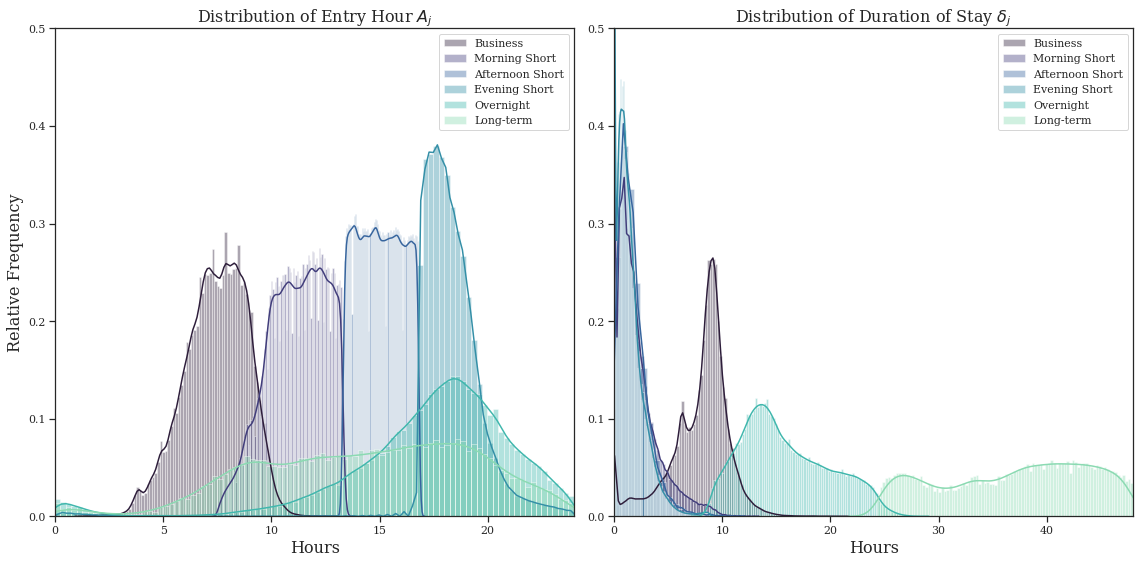

In [22]:
cluster_viz(parkings,"EntryMFM","HoursStay",
            cluster_order=["Business","Morning Short","Afternoon Short","Evening Short","Overnight","Long-term"],
            cluster_indicator="ClusterName",#set 
            titles=["Entry Hour $A_{j}$","Duration of Stay $\delta_{j}$", "Demanded Energy [kWh]"], file_name="Cluster_Distribution_Plot_2vars"
            ) 

__Cluster Property Table Overview__

In [18]:
# Entry time, Stay Duration, Miles requested, Energy requested, Lax


overview_table = parkings.groupby("ClusterName").agg({"EntryMFM":"mean","HoursStay":"mean","userInputs_kWhRequested":"mean","userInputs_milesRequested":"mean"})

overview_table.columns=["EntryHour","HourStay","kWhRequested","MilesRequested"]
overview_table["EntryHour"] = overview_table["EntryHour"]/60
#overview_table["AvgLaxity"] = overview_table["EntryHour"]/60


In [19]:
overview_table

,EntryHour,HourStay,kWhRequested,MilesRequested
ClusterName,,,,
Afternoon_short,15.054769,1.732555,21.487959,62.126760
Business,7.436819,7.922647,25.633076,73.068748
Evening_short,18.289431,1.469293,21.430979,62.966561
Long-term,14.458538,37.038609,33.134641,105.058755
Morning_short,11.159884,2.123360,21.556828,63.321814
Overnight,17.362190,15.841722,38.059693,107.583391


<AxesSubplot:xlabel='userInputs_kWhRequested'>

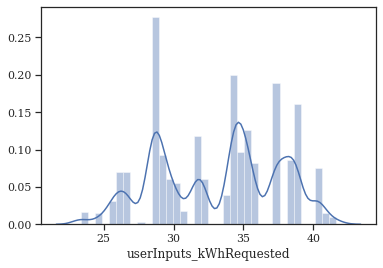

In [39]:
sns.distplot(parkings[parkings["ClusterName"]=="Long-term"]["userInputs_kWhRequested"])

__Save Results__

In [40]:
parkings.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'EntryDateTime', 'ExitDateTime',
       'HoursStay', 'MinutesStay', 'RevenueAmount', 'SiteID', 'Year',
       'EntryMFM', 'ExitMFM', 'EntryDate', 'ExitDate', 'EntryHour', 'ExitHour',
       'EntryHour_sin', 'EntryHour_cos', 'EntryMin_sin', 'EntryMin_cos',
       'ExitHour_sin', 'ExitHour_cos', 'ExitMin_sin', 'ExitMin_cos',
       'EntryDayOfWeek', 'EntryWeekday_yn', 'EntryHoliday_yn',
       'userInputs_WhPerMile', 'userInputs_kWhRequested',
       'userInputs_milesRequested', 'MaxFeasible_kwhRequested',
       'final_kWhRequested', 'ClusterNum', 'ClusterName'],
      dtype='object')

In [41]:
out_cols = ['EntryDateTime', 'ExitDateTime', 'HoursStay',
       'MinutesStay', 'RevenueAmount', 'SiteID', 'Year', 'EntryMFM', 'ExitMFM',
       'EntryDate', 'ExitDate', 'EntryHour', 'ExitHour', 'EntryDayOfWeek',
       'EntryWeekday_yn', 'EntryHoliday_yn', 'userInputs_WhPerMile',
       'userInputs_kWhRequested', 'userInputs_milesRequested',
       'MaxFeasible_kwhRequested','final_kWhRequested','ClusterNum', 'ClusterName']

#parkings = parkings[out_cols]

In [42]:
parkings.to_csv(DATA_PATH+"EV_Energy_Demand_Data/Parking+Charging_Data_BLENDED_CLUSTERED.csv")

__Share of Parker Types per facility__

In [43]:
#count parking events
total_parkings = pd.DataFrame(parkings[["SiteID","EntryDateTime"]].groupby(["SiteID"]).count())
total_parkings.columns=["TotalParkings"]
total_parkings.reset_index(inplace=True)
facility_properties = parkings[["SiteID","ClusterName","EntryDateTime"]].groupby(["SiteID","ClusterName"]).count()
facility_properties.columns=["NumParkings"]
facility_properties.reset_index(inplace=True)

#merge
facility_data = facility_properties.merge(total_parkings, on="SiteID",how="left")
facility_data["Share"] = facility_data["NumParkings"]/facility_data["TotalParkings"]

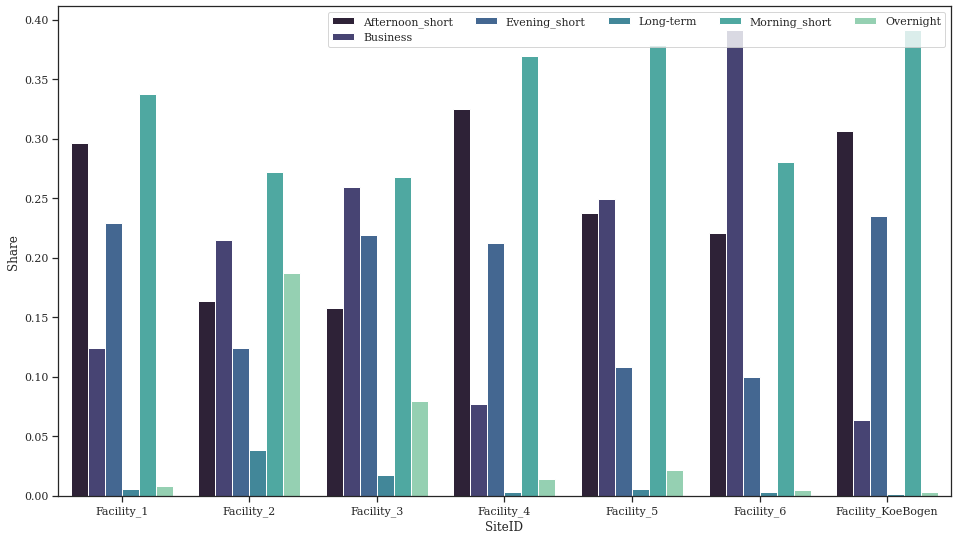

In [44]:
f, ax = plt.subplots(figsize=(16, 9),sharey=True)
sns.barplot(data=facility_data,x="SiteID",y="Share",hue="ClusterName",palette="mako",ax=ax)
ax.legend(loc='upper right',ncol=5)

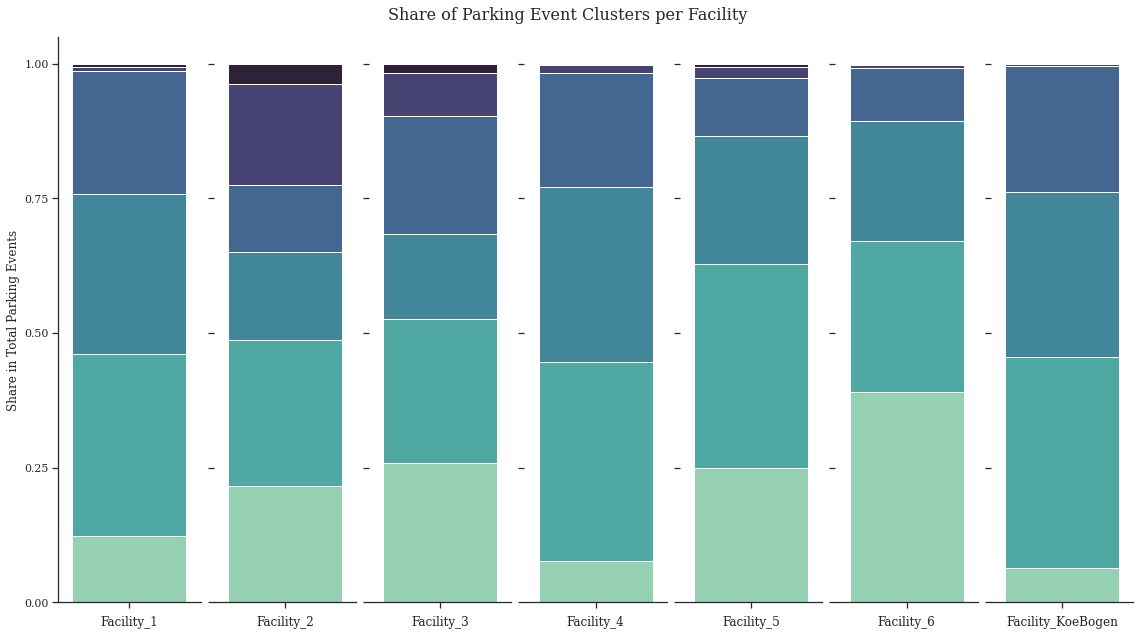

In [61]:
file_name="Composition_per_facility"
facilities = ["Facility_1","Facility_2","Facility_3","Facility_4","Facility_5","Facility_6","Facility_KoeBogen"]
clusters=["Business","Morning_short","Afternoon_short","Evening_short","Overnight","Long-term"]
clusters.reverse()
custom_pal = sns.color_palette("mako",len(clusters))

f, ax = plt.subplots(1,len(facilities),figsize=(16, 9),sharey=True)


#loop through facilities
facility_i=0
for facility_name in facilities:
    
    # get data
    data=facility_data[facility_data["SiteID"]==facility_name][["ClusterName","Share"]].T
    data.columns = data.iloc[0]
    data.drop(data.index[0],inplace=True)

    # get cumulative share (TODO: Make this dynamic)
    data["BusinessCum"]= data["Business"]
    data["Morning_shortCum"]= data["BusinessCum"]+data["Morning_short"]
    data["Afternoon_shortCum"]=data["Morning_shortCum"] + data["Afternoon_short"]
    data["Evening_shortCum"]=data["Afternoon_shortCum"] + data["Evening_short"]
    data["OvernightCum"]=data["Evening_shortCum"] + data["Overnight"]
    data["Long-termCum"]=data["OvernightCum"] + data["Long-term"]

    
    #plot data
    #handles=[]
    for i in range(len(clusters)) :

        sns.barplot(y="{}Cum".format(clusters[i]), data=data, color=custom_pal[i], ax=ax[facility_i]) #
        
        ax[facility_i].set_xlabel(facility_name)
        
        if facility_i==0:
            ax[facility_i].set_ylabel("Share in Total Parking Events")
            ax[facility_i].set_yticks([0,0.25,0.5,0.75,1.0])
            #ax[facility_i].legend(ncol=2, loc="lower right", frameon=True)
            #ax[facility_i].legend(clusters)
            sns.despine(ax=ax[facility_i], left=False, bottom=False)
            
        else:
            ax[facility_i].set_ylabel("")
            sns.despine(ax= ax[facility_i],bottom=False,left=True)
            #ax[facility_i].set_yticks([])
            #ax[facility_i].axis('off')
        
        #handles.append(handle)
        
    facility_i+=1
    
#TODO: Fix Legend
#f.legend(labels=clusters,ncol=(len(clusters)), loc='lower center')
f.suptitle('Share of Parking Event Clusters per Facility ', fontsize=16)

plt.tight_layout()
#plt.savefig("{}.pdf".format(file_name))
plt.show()   

__Typical Occupancy Profile__

In [66]:
#parkings.info()

In [67]:
def round_down_to_base (num,base):
    return num - (num%base)  

In [68]:
# settings
facilities = ["Facility_1","Facility_2","Facility_3","Facility_4","Facility_5","Facility_6","Facility_KoeBogen"]#["Facility_1","Facility_2","Facility_3","Facility_4","Facility_5","Facility_6","Facility_KoeBogen"]
clusters=["Business","Morning_short","Afternoon_short","Evening_short","Overnight","Long-term"]
agg_level = 5 #minutes

# set entry/exit time to five min res
parkings["EntryDateTime"] = pd.to_datetime(parkings["EntryDateTime"])
parkings["EntryDateTime5min"] = parkings["EntryDateTime"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute,5)))

parkings["ExitDateTime"] = pd.to_datetime(parkings["ExitDateTime"])
parkings["ExitDateTime5min"] = parkings["ExitDateTime"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute,5)))#.apply(lambda x: x.replace(second=0, microsecond=0))


# count entries and exits per time period in separate df
entry_counts = parkings[["SiteID","ClusterName","EntryDateTime5min","ExitDateTime5min"]].groupby(["SiteID","ClusterName","EntryDateTime5min"]).count()
entry_counts.columns=["EntryCounts"]
entry_counts.reset_index(inplace=True)

exit_counts = parkings[["SiteID","ClusterName","EntryDateTime5min","ExitDateTime5min"]].groupby(["SiteID","ClusterName","ExitDateTime5min"]).count()
exit_counts.columns=["ExitCounts"]
exit_counts.reset_index(inplace=True)

In [72]:
# compute target index
target_index = pd.DataFrame()
for facility in facilities:
    for cluster in clusters:
        df=pd.DataFrame()
        df["datetime"]= pd.date_range(start=parkings["EntryDateTime5min"].min(), end=parkings["ExitDateTime5min"].max(),freq="{}S".format(agg_level*60))
        df["facility"] = facility
        df["cluster"] = cluster
        df["key"] = df.apply(lambda x: "{}_{}_{}".format(x.facility,x.cluster,x.datetime),axis=1) 
        
        print(facility,cluster)
        
        target_index = target_index.append(df) 
        

# merge entries and exits

# create keys
entry_counts["key"] = entry_counts.apply(lambda x: "{}_{}_{}".format(x.SiteID,x.ClusterName,x.EntryDateTime5min),axis=1) 
exit_counts["key"] = exit_counts.apply(lambda x: "{}_{}_{}".format(x.SiteID,x.ClusterName,x.ExitDateTime5min),axis=1) 

# merge with target
occupancy = target_index.merge(entry_counts[["key","EntryCounts"]], on="key", how="left")
occupancy = occupancy.merge(exit_counts[["key","ExitCounts"]], on="key", how="left")
occupancy.fillna(0,inplace=True)

Facility_1 Business
Facility_1 Morning_short
Facility_1 Afternoon_short
Facility_1 Evening_short
Facility_1 Overnight
Facility_1 Long-term
Facility_2 Business
Facility_2 Morning_short
Facility_2 Afternoon_short
Facility_2 Evening_short
Facility_2 Overnight
Facility_2 Long-term
Facility_3 Business
Facility_3 Morning_short
Facility_3 Afternoon_short
Facility_3 Evening_short
Facility_3 Overnight
Facility_3 Long-term
Facility_4 Business
Facility_4 Morning_short
Facility_4 Afternoon_short
Facility_4 Evening_short
Facility_4 Overnight
Facility_4 Long-term
Facility_5 Business
Facility_5 Morning_short
Facility_5 Afternoon_short
Facility_5 Evening_short
Facility_5 Overnight
Facility_5 Long-term
Facility_6 Business
Facility_6 Morning_short
Facility_6 Afternoon_short
Facility_6 Evening_short
Facility_6 Overnight
Facility_6 Long-term
Facility_KoeBogen Business
Facility_KoeBogen Morning_short
Facility_KoeBogen Afternoon_short
Facility_KoeBogen Evening_short
Facility_KoeBogen Overnight
Facility_KoeB

In [73]:
# get net occupancy change per faclity, cluster and period
occupancy["NetOccupancyChange"] = occupancy["EntryCounts"]-occupancy["ExitCounts"]

# get total occupancy as cumulative sum

occupancy_final = pd.DataFrame()

for facility in occupancy["facility"].unique():
    for cluster in occupancy["cluster"].unique():
        
        df = occupancy[(occupancy["facility"]==facility)&
                       (occupancy["cluster"]==cluster)]
        
        df.sort_values(by="datetime",inplace=True)
        
        df["TotalOccupancy"] = df["NetOccupancyChange"].cumsum()
        
        
        occupancy_final = occupancy_final.append(df)
        
occupancy_final["date"] = occupancy_final["datetime"].apply(lambda x: x.date())

__Plot occupancy profile__

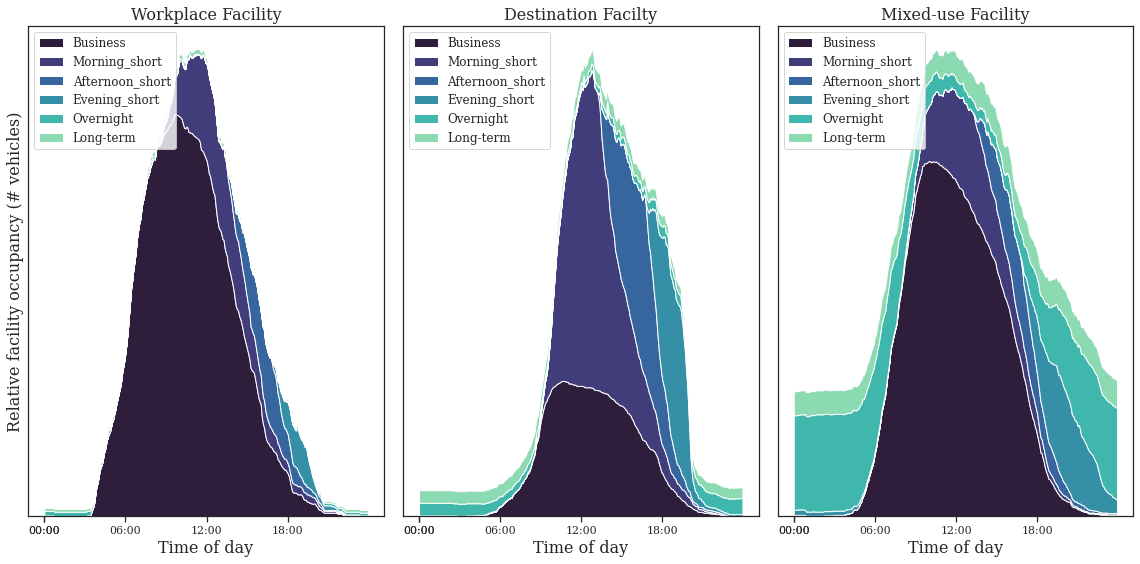

In [185]:
# plotting

from datetime import time

date = pd.to_datetime("2019-06-05")  # this is a Tueasday
#facility = "Facility_6"
#facility = "Facility_3"


facilities_selected = ["Facility_6","Facility_4","Facility_3"] #facilities:#
fig, ax = plt.subplots(1,len(facilities_selected),figsize=(16,8))

title_dict = {"Facility_6":"Workplace Facility","Facility_4":"Destination Facilty","Facility_3":"Mixed-use Facility"}

i = 0
for facility in facilities_selected:
        
    plot_data = occupancy_final[(occupancy_final["facility"]==facility)&(occupancy_final["date"]==date)]
    plot_data["time"] = plot_data["datetime"].apply(lambda x: time(hour = x.hour, minute = x.minute, second = x.second))

    # get arrays of data series
    x=np.array(plot_data[plot_data["cluster"]=="Business"]["time"])
    y1=np.array(plot_data[plot_data["cluster"]=="Business"]["TotalOccupancy"])
    y2=np.array(plot_data[plot_data["cluster"]=="Morning_short"]["TotalOccupancy"])
    y3=np.array(plot_data[plot_data["cluster"]=="Afternoon_short"]["TotalOccupancy"])
    y4=np.array(plot_data[plot_data["cluster"]=="Evening_short"]["TotalOccupancy"])
    y5=np.array(plot_data[plot_data["cluster"]=="Overnight"]["TotalOccupancy"])
    y6=np.array(plot_data[plot_data["cluster"]=="Long-term"]["TotalOccupancy"])

    labels = clusters

    ax[i].stackplot(x,y1,y2,y3,y4,y5,y6,labels=labels,colors=custom_pal)
    ax[i].legend(loc='upper left', fontsize=12)
    ax[i].set_ylabel('Relative facility occupancy (# vehicles)', fontsize=16)
    ax[i].set_xlabel('Time of day', fontsize=16)
    
    if facilities_selected.index(facility)>0:
        ax[i].set_ylabel('')
    
    ax[i].set_title("{}".format(title_dict[facility]),fontsize=16)
    ax[i].set_yticks([])
    
    ax[i].set_xticks([time(hour = 0),time(hour = 6),time(hour = 12),time(hour = 18),time(hour = 0)])
    
    i+=1
plt.tight_layout()
plt.savefig("Occupancy_profile_Sample_Facilities.pdf")

plt.show()

---